In [1]:
!pip install mlxtend machine-learning-datasets rulefit interpret gaminet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 881.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.5/752.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.0/242.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 1

In [2]:
# vamos a predecir los minutos de retraso de un vuelo(predictor) y si es un vuelo que se retrasa mas de 15 minutos o no (clasificador)
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,\
                                  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes,\
                    neighbors, ensemble, neural_network, svm

from rulefit import RuleFit
import statsmodels.api as sm

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

import tensorflow as tf
from gaminet import GAMINet
from gaminet.utils import plot_trajectory, plot_regularization,\
                    local_visualize, global_visualize_density,\
                    feature_importance_visualize

import matplotlib.pyplot as plt


In [3]:
aad18_df = mldatasets.load("aa-domestic-delays-2018")
print(aad18_df.info())
#PLANNED_DEP_DATETIME: 2018-01-01 11:55:00

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip downloaded to /content/data/aa-domestic-delays-2018.csv.zip
/content/data/aa-domestic-delays-2018.csv.zip uncompressed to /content/data/aa-domestic-delays-2018.csv
1 dataset files found in /content/data/aa-domestic-delays-2018.csv folder
parsing /content/data/aa-domestic-delays-2018.csv/aa-domestic-delays-2018.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             

Data Preparation

In [4]:
# change  PLANNED_DEP_DATETIME type to datetime type
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])

# the exact day and tmie of flight don realy matter but maybe the month and day do for weather or seasonal patterns
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek

# and now we dont need the datetime column
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

In [5]:
# Vamos a eliminar las filas de FL_NUM, ORIGEN Y DESTINO y solo vamos a quedarnos con que si el origen es un aeropuerto de la empresa AA(que estamos estudiando) y a parte si el destino es un aeropuerto
# de la empresa AA

# creamos la lista con los codigos IATA de los 10 aeropuertos que tiene esta empresa
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL',\
        'PHX', 'DCA']

# creamos las columnas booleanas indicadas antes y eliminamos las que ya no nos hacen falta
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)

aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub,'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub,'ORIGIN_HUB'] = 1

aad18_df = aad18_df.drop(['FL_NUM','ORIGIN','DEST'],axis=1)

In [6]:
# vamos a seleccionar ahora las caracteristicas de salida. ARR_DELAY  nos indica el delay generado en total, no solo por el aeropuerto y CARRIER_DELAY es el delay por el aeropuerto(que es lo que le
# interesa ya que puedes mejorarlo) y tambien vamos a hacer una columna booleana que nos indique si la espera es mayor de 15 minutos o no (tambien le interesa a la empresa)
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY', 'CARRIER_DELAY']].head(10)

# vamos a eliminar el ARR_DELAY ya que no nos interesaría (por la definición del problema inicial) ademas que queremos predecir retrasos por el aeropuerto y por esto sobre todo
# no podemos utilizar retrasos medidos en "unidades" de retrasos en provocados en general.
aad18_df = aad18_df.drop(['ARR_DELAY'],axis=1)

Dividmos los datos en X e Y, importante destacar que para regresion la y se mantiene igual pero para clasificación vamos a binarizar la salida. 0 si el retraso es menor de 15 min, y 1 si es mayor

In [7]:
rand = 9 # para que sea reproducible
np.random.seed(rand)
y= aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'],axis=1).copy()
# salida para regresion y datos de entrada para clasificacion y regresion
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X,y,test_size=0.15, random_state=rand)

# salida binarizada para clasificacion
y_train_class = y_train_reg.apply(lambda x: 1 if x >15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x >15 else 0)

Usamos la correlación de Pearson para ver como de linealmente relacionados están los datos de entrada al objetivo CARRIER_DELAY.

Vamos a poner los coeficientes en termios absolutos (ya que no nos importa si estan relacionados positiva o negativamente y los ordenamos en orden descendente)

In [8]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

# ten en cuenta que esto solo mide la relación lineal de cada uno de los atributos de entrada con la salida, no tiene en cuenta relaciones no lineales ni si
# la combinación de variós atributos puede tener un impacto considerable con el objetivo.

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
ORIGIN_HUB             0.000221
DEST_HUB                    NaN
Name: CARRIER_DELAY, dtype: float64

In [9]:
# createa a bunch of models for regression in order to contrast them (store fitted model and its metrics)
reg_models = {
    # Generalized Linear Models (GLMs)
    'linear':{'model': linear_model.LinearRegression()},
    'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                                          linear_model.LinearRegression(fit_intercept=False))},
    'linear_interact':{'model':make_pipeline(PolynomialFeatures(interaction_only=True),
                                             linear_model.LinearRegression(fit_intercept=False))},
    'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3,1e-2,1e-1,1])},
    #Trees
    'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
    #RuleFit
    'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)},
    # Nearest Neighbors KNN tarda muchisimo en entrenar
    #'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)},
    #Ensemble Methods
    'random_forest':{'model': ensemble.RandomForestRegressor(max_depth=7, random_state=rand)},
    # Neural Networks
    'mlp':{'model': neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, early_stopping=True, random_state=rand)}
}

LinearRegression -> asume que el resultado es combinacion lineal de los atributos. Esto limita bastante al modelo

PolynomialRegresion -> Para cada dato va a añadir tambien el dato^2 y la multiplicacion de cada dato por el resto de datos(pej DEP_FHP*DELAY)

linear_interact -> Hace lo mismo que el anterior pero sin el dato^2, solo multiplica tiene tambien en cuenta la multiplicacion entre datos esto se hace co el parametro (interaction_only).

Ridge-> Es una variación de la regresion lineal. La regresion lineal normal funciona bastante bien pero cuando hay muchos atributos tienede al overfitting ya que trata a todos los atributos por igual (menor sesgo posible pero mayor varianza (overfitting)). Aqui es donde entra la regresion de Ridge en donde vamos a jugar con el sesgo y la varianza reduciendo la complejidad introducida al usar varios atributos usando la regularización (reduciendo coeficientes que no contribuyen a la salida con terminos de penalización llamados L2 norm). Penalizamos la complejidad basicamente reduciendo el overfitting. En nuestro caso usamos una validación cruzada de Ridge(RidgeCV) que prueba varias fuerzas de regularización (alphas)

Trees: limitamos la profundidad a 7 para evitar overfitting. A mas profundidad, menos posibilidades de generalizar.

rule_fit: haze una regresion lineal regularizada con  una regresion de Lasso, es decir, como Ridge usa regularización pero usa un arbol de decision para generar estas reglas (interacciones entre atributos) y descartando los hojas para continuar obteniendo reglas. En este caso no usa L2 norm, usa L1 norm lo que hace que los coeficientes inutiles no tiendan a 0 y sean directamente 0 haciendo mas facil para el algoritmo que los filtre. Se limita el maximo de reglas a 0 y se indica que queremos usarlo para regresion ya que este modelo tambien se podría usar para clasificacion.

KNN: usa el dataset original y mide la distancia de los puntos vecinos al dato de entrada. La clase con mas puntos cercano al dato de entrada es el valor de la predicción. K = numero de vecinos que quieres tener en cuenta.

Random forest: Generamos cientos de random forest a partir de combinaciónes aleatorias del dataset y juntamos todos estos arboles "debiles" para crear un arbol robusto usando la media. Este tipo de metodo que combina muchos modelos debiles en uno fuerte se llama embolsado y con arboles funcionan bien por que reducen la varianza. Por eso usamos una profundidad maxima de 7.

MLP: Multilayer perceptron: Feedforward(sequential) neural network, relu activation funtion,stochasctic gradient and back propagation. We use una layer of 21 neurons hiddel_layer_sizes(21,), 500 epochs and stop if validation score is not improving



# Train the models and save prediccitions and metrics

In [10]:

for model_name in reg_models.keys():
  print(model_name)
  if model_name != 'rulefit': # rulefeet needs numpy array
    fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
  else:
    fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)

  reg_models[model_name]['fitted'] = fitted_model
  reg_models[model_name]['preds'] = y_test_pred
  reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
  reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
  reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg,y_test_pred)

linear
linear_poly
linear_interact
ridge
decision_tree
rulefit
random_forest
mlp


Metrica R2 =  1-(sumatorio salida - prediccion)^2/(sumatorio salida-media de la salida)^2. 1 es el mejor resultado y 0 el peor

In [11]:
# Convertimos el diccionario en un Marco de datos y lo mostramos con distintos colores
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.format({'RMSE_train':'{:.2f}', 'RMSE_test': '{:.2f}', 'R2_test': '{:.3f}'}).\
    background_gradient(cmap='viridis_r', low=0.1, high=1, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.1, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
mlp,3.16,3.22,0.988
random_forest,5.14,6.07,0.956
linear_poly,6.23,6.36,0.952
linear_interact,6.47,6.56,0.949
decision_tree,6.54,7.47,0.934
linear,7.83,7.89,0.926
ridge,7.83,7.89,0.926
rulefit,8.77,8.84,0.907


# Interpretación de los resultados:
##RMSE:
Root Mean Square Error esta definido como la desviación estandard de los residuos. Te indica en media como de lejos estan las predicciónes de los valores reales y cuanto menor sea esta medida, mejor. Lo normal es que el RMSE de test sea un poco mayor que los de train pero no por mucho como pasa para random forest en el que habría que cambiar un poco los parametros para reducir el overfitting como por ejemplo reducir la profundidad maxima de los árboles(estimadores) y reducir el numero maximo de caracteristicas. Para KNN puedes cambiar el numero de vecinos K pero es normal que este algoritmo al usar el dataset entero para sus predicciones, que funcione mejor de lo que realmente funciona con los datos de entrenamiento.

Igualmente los resultados están bastante bien ya que todos calculan un retraso medio por debajo de 10 minutos y la mitad de ellos alrededor de los 7.5 minutos siendo muy posible que predizcamos el retraso con eficiencia ya que el limite para los retrasos calculados que queriamos era de 15 minutos.

*Date cuenta que linear_poly y linear_interact estan bastante por delante de linear revelandonos que la no-linealridad y la interaccion de los datos(combinaciones entre datos) son relevantes.

##R^2 o coeficiente de determinación
Indica que cantidad de variabilidad de los datos de salida y es explicable con los datos de entrada X. Cuanto mas grande sea, mejor. Si tuviesemos un valor bajo seria buena idea añadir mas datos aunque pudiesen parecernos no relevantes.
Basicamente indica que proporcion de variabilidad de y es explicable con las características de X


# Clasificando vuelos como retrasado o no retrasado con varios metodos de clasificación

In [12]:
# createa a bunch of models for classification in order to contrast them (store fitted model and its metrics)
class_models = {
    # Generalized Linear Models (GLMs)
    'logistic':{'model': linear_model.LogisticRegression()},
    'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3,1e-2,1e-1,1], class_weight='balanced')},
    #Trees
    'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
    # Nearest Neighbors tarda la vida en entrenar (mas de 40min)
    #'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)},
    # Naive Bayes
    'naive_bayes':{'model': naive_bayes.GaussianNB()},
    #Ensemble Methods
    'gradient_boosting':{'model': ensemble.GradientBoostingClassifier(n_estimators=210)},
    'random_forest':{'model': ensemble.RandomForestClassifier(max_depth=11, class_weight='balanced',random_state=rand)},
    # Neural Networks
    'mlp':{'model': make_pipeline(StandardScaler(),neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500, early_stopping=True, random_state=rand))}
}

# Explicacion Modelos de Clasificación
## Regresion Logistica:
Tiene muchos de los pros y contras de la regresion lineal como por ejemplo que la interaccion entre atributos debe ser añadida a mano. Retorna una probablildad entre 0 prediccion negativa y 1 prediccion positiva teniendo 0.5 como umbral de prediccion aunque este valor puede cambiar para algunos casos

## Ridge:
Funciona como hemos visto para regresion pero en este caso primero se pasa los datos de entrada a valores entre -1 y 1(pred.positiva) y despues se realiza una regresion de Ridge que es convertida a valores entre 0 y 1. Como hemos visto antes se usa la tecnida de leave-one-out-cross-validation lo que significa que se dividen los datos en distintos conjuntos de igual tamaño (5 en nuestro caso ya que usamos el arguento cv=5) y se van eliminando argumentos (uno por prueba) para ver si al eliminarlo perdemos mucha información o no. Si no se pierde informacioin casi esta caracteristica es penalizada probando con distintas fuerzas de regularización (alfa) para encontrar la fuerza optima. La idea es eliminar caracteristicas que no aportan demasiada información reduciendo la complejidad del modelo y reduciendo el impacto de caracteristicas menos significativas.

##Arboles de decision:
Tiene el mismo funcionamiento que para regresion. solo cambia donde decide hacer una separación de las ramas. En este caso solo permitimos una profundidad maxima de 7

##KNN:
ahora en lugar de predecir un valor usando la media de los k vecinos mas cercanos predecimos la clase viendo cual tiene mas frecuencia de los k vecinos mas cercanos.

# Naive bayes classifier:

Es un clasificador de la familia Naive Classifier. Se le llama Naive por que se asume que los datos de entrada son independientes de los otros (lo cual no suele ser el caso). Esto impide dramaticamente las correctas predicciones a no ser que la condicion sea cierta. En este caso usamos la probabilidad condicionada de bayes para los datos de entrada. Además este clasifador en nuestro caso asume también que los datos continuos tienen una distribucion normal (distribución gausiana)

# Gradient boosting:
Gradient boosting trees usan la misma tecnica que Random forest pero con boosting en lugar de bagging. Boosting no se puede hacer en paralelo, tiene que ser secuencial entrenando iterativamente aprendices debiles e incorporando sus puntos fuertes a aprendices mas fuertes mientras adapta a otro aprendiz mas debil para eliminar sus debilidades. En nuestro caso usamos 210 arboles(n_estimators)

# random forest:
Como el caso de regresion pero para clasificación

# MLP
El mismo perceptron multicapa salvo que ahora usamos una funcion logistica en la última capa para que los valores de salida estén entre 0 y 1 con un umbral de 0.5 y solo usamos una capa oculta de 7 capas ya que la clasificacion binaria tiene a usar menos neuronas/capas para obtener resultados optimos

*Importante destacar que varios modelos usan el argumento "class_weight"=balanced. Esto se debe a que el número de clases negativas sobrepasa por mucho al número de clases positivas. Este argumento hace que se aplique un peso proporcional inverso a la frecuencia de la clase ayudando a los datos de las clases positivas. Podemos verlo asi:

In [13]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0]) # clases positivas = 6% solo.

0.061283264255549


#Entrenamiento y evaluación:
Vamos a entrenar los modelos, guardar las probabilidades de las predicciones y pesos(excepto para ridge que no retorna probabilidades), y evaluarlos con 5 métricas.
*gradient_boosting tarda la vida en entrenar.

In [14]:
for model_name in class_models.keys():
  print(model_name)
  fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
  y_train_pred = fitted_model.predict(X_train)
  if model_name == 'ridge':
    y_test_pred = fitted_model.predict(X_test)
  else:
    y_test_prob = fitted_model.predict_proba(X_test)[:,1]
    y_test_pred = np.where(y_test_prob > 0.5,1,0)

  class_models[model_name]['fitted'] = fitted_model
  class_models[model_name]['probs'] = y_test_prob
  class_models[model_name]['preds'] = y_test_pred
  class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
  class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
  class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class,y_train_pred)
  class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class,y_test_pred)
  if model_name != 'ridge':
    class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
  else:
    class_models[model_name]['ROC_AUC_test'] = np.nan
  class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
  class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

logistic


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ridge
decision_tree
naive_bayes
gradient_boosting
random_forest
mlp


# Y convertimos el diccionario en un DataFrame y mostramos las métricas

In [15]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    format(dict(zip(class_metrics.columns, ['{:.3f}']*7))).\
    background_gradient(cmap='plasma', low=1, high=0.1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.1, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.998,0.998,0.982,0.984,1.000,0.986,0.985
gradient_boosting,0.992,0.992,0.891,0.894,0.999,0.931,0.928
random_forest,0.936,0.935,1.000,0.993,0.995,0.651,0.669
decision_tree,0.983,0.983,0.857,0.852,0.995,0.859,0.850
logistic,0.975,0.975,0.699,0.698,0.959,0.776,0.769
naive_bayes,0.925,0.925,0.272,0.266,0.824,0.304,0.269
ridge,0.888,0.889,0.739,0.740,nan,0.449,0.440


# Interpretación de las métrias:

## Accuracy:
Cantidad de predicciones acertadas entre cantidad total de predicciones

## Recall
Estudia la sensibidad o ratio de verdaderos positivos. Imagina que tenemos una tasa de acierto del 94% esto puede parecer muy bueno pero ya hemos visto que solo el 6% de nuestros datos son clases positivas entonces podria estar nuestro modelo estar prediciendo todo el rato que es falso debido al sobreajuste es por esto que Recall es mucho mejor que el accuracy para este caso ya que nos permite medir como fueron las verderas predicciones relevantes. Se calcula:
Verdaderos positivos/(verdaderos positivos + falsos negativos). Otra medida que involucra los verdaderos positivos es precisión que indica cuantas veces nuestra predicciones obtenidas son relevantes que se calcula como: verdaderos positivos/(verdaderos positivos+falsos positivos). Se recomienda usar las dos aunque dependiendo de tu preferencia por los falsos negativos o falsos positivos preferiras recall por encima de precisión o viceversa.

## ROC-AUCC:
ROC(Receiver Operating Characteristic): Fue diseñado para separar señal del  ruido. Lo que hace es representar la proporcion de verdaderos positivos (recall) en el eje X y la proporción de falsos positivos en el eje y. AUC(Area Under de Curve) es un numeor entre 0 y 1 que mide la habilidad de prediccion de nuestro modelo siendo 1 perfecto, 0.5 igual de bueno que tirar una moneda al aire y 0 indicandonos que si invertimos el resultado de nuestro modelo obtendriamos una mejor actuación. Para mostrar esto vamos a representar una curva ROC para nuestro peor modelo (Naive_bayes)

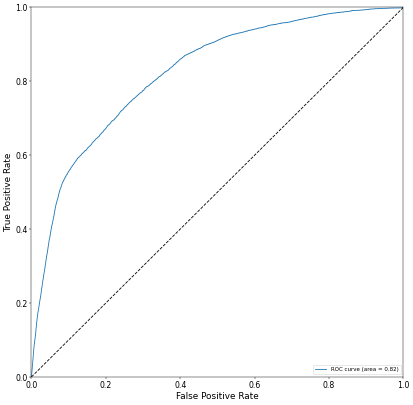

In [16]:
plt.figure(figsize=(12,12),dpi=40)
plt.tick_params(axis='both', which='major', labelsize=14)
fpr,tpr,_ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--') # coin toss line
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")
plt.show()

*La linea diagonal representa la mitad del area lo que representaría tirar una moneda al aire

## F1:
La metrica F1 es tambien llamada la media harmonica de la precision y el recall ya que se calcula como: 2*verdaderos_positivos/(2*verdaderos_positivos + falsos positivos + falsos negativos). Como tiene en cuenta tanto la precisión como el recall es una buena metrica cuando tus datos estan desbalanceados y no tienes preferencia por la precision o por el recall.

## Coeficiente de correlación de Matheus:
Es una formula muy larga que tiene en cuenta tanto Verdaderos y falsos positivos como verdaders y falsos negativos de una forma justa. Hace que sea optmo para datos desbalanceados para tareas de clasificación. NO VA DE 0 A 1 si no que va desde -1 (total desacuerdo), a 1(total acuerdo) entre predicciones y resultados reales. 0 equivale a una predicción aleatoria.

# Interpretacion de un modelo lineal General
Los pesos obtenidos para cada atributo nos cuentan basicamente todo.

# Regresion Lineal

In [17]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_ # la b de la formula o sesgo o w0
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.49836643e-03 -5.28519667e-03  8.93857932e-01 -2.03370349e-02
 -4.76781547e-01  1.20931054e-01 -5.81878561e-04 -1.58962342e-02
  4.52458484e+01  1.01382455e-03 -3.60583836e-04  2.41761836e-03
  3.71982154e-01 -9.06800672e-01 -6.73626772e-01 -9.18814034e-01
 -9.29300927e-01 -4.12593109e-02 -1.99311008e-02  2.27124149e+00
  0.00000000e+00]
intercept:	-40.72718054823273


In [18]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2])) # como se calcula la prediccion

ŷ = -40.73 + 0.0045X₁ + -0.0053X₂ + 0.894X₃ + ...


In [19]:
# convertimos los pesos en un data frame para que se vea mejor
pd.DataFrame({'feature': X_train.columns.tolist(), 'coef':coefs_lm.tolist()})

,feature,coef
0,CRS_DEP_TIME,0.004498
1,DEP_TIME,-0.005285
2,DEP_DELAY,0.893858
3,DEP_AFPH,-0.020337
4,DEP_RFPH,-0.476782
5,TAXI_OUT,0.120931
6,WHEELS_OFF,-0.000582
7,CRS_ELAPSED_TIME,-0.015896
8,PCT_ELAPSED_TIME,45.245848
9,DISTANCE,0.001014


## Como interpretar un atributo en funcion de sus caracteristicas:
- Atributo con valores continuos: DEP_DELAY	0.893858 sabemos que para unidad de DEP_DELAY el retraso predicho va a aumentar en 0.893858 si ningun otro atributo cambia

- Atributo con valores binarios: ORIGIN_HUB	2.271241 indica la diferencia entre que el aeropuerto de origen sea un HUB o no es expresada por el coeficiente 2.271241. En otras palabras, como es positivo el origen no es un aeropuerto y aumenta el tiempo de retraso en 2,27 minutos.

- Atributo categorico: no tenemos en nuestro caso pero si tenemos caracteristicas ordinales que podrian haber sido y deberian haberlo sido para DEP_MONTH(0-12) y DEP_DOW(0-6). Esto se ha hecho a posta para ver que esto está mal hecho y podria haber afectado a nuestro modelo para obtener buenos resultados. Basicamente al haber mantenido estos atributos como numeros ordinales y no como categorias usando dummy o one-hot encoded matrix. Al no haber hecho esto estamos asumiendo que hay una relacion lineal entre el dia de la semana y mes del año (a mas grande mayor delay) cosa que no es asi y por ende no estamos pudiendo medir bien el impacto que tiene el dia de la semana o mes del año y podria haber afectado a nuestro modelo considereablemente (no es el caso)

El intercept tambien tiene un significado y es cual sería la predicción si todos los atributos a predecir fuesen 0. si estandarizaces todos tus datos para que tengan una media 0 la interpretacion del intercept seria cual es la prediccion que esperas si todas las caracteristicas fuesen su valor medio.

Los coeficientes tambien pueden indicarnos la importancia de una caracteristica a la hora de realizar predicciones usando el erro estandard de los coeficientes. Scikit-learns no lo hace pero la libreria statsmodels si

In [20]:
linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
print(linreg_mdl.summary())
# T-statistic es lo que nos dice que atributo es mas importante respecto de los otros

                            OLS Regression Results                            
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.454e+05
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:57:09   Log-Likelihood:            -2.6582e+06
No. Observations:              764597   AIC:                         5.316e+06
Df Residuals:                  764576   BIC:                         5.317e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -40.7272    

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [21]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index().rename(columns={'index':'feature'}) # quitamos el intercept ya que no es un atributo
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.format(dict(zip(summary_df.columns[1:], ['{:.4f}']*7))).background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|','t_abs'])
# el valor T-statisic y P value esta inversamente relacionado. Cualquier coeficiente con valor p > 0.05 es insignificante

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
2,DEP_DELAY,0.8939,0.0003,2948.0794,0.0000,0.8933,0.8945,2948.0794
16,LATE_AIRCRAFT_DELAY,-0.9293,0.0005,-1825.0315,0.0000,-0.9303,-0.9283,1825.0315
13,WEATHER_DELAY,-0.9068,0.0009,-994.9696,0.0000,-0.9086,-0.9050,994.9696
14,NAS_DELAY,-0.6736,0.0008,-828.7946,0.0000,-0.6752,-0.6720,828.7946
8,PCT_ELAPSED_TIME,45.2458,0.1170,386.6648,0.0000,45.0165,45.4752,386.6648
15,SECURITY_DELAY,-0.9188,0.0055,-167.9549,0.0000,-0.9295,-0.9081,167.9549
5,TAXI_OUT,0.1209,0.0012,100.8519,0.0000,0.1186,0.1233,100.8519
3,DEP_AFPH,-0.0203,0.0003,-73.6295,0.0000,-0.0209,-0.0198,73.6295
0,CRS_DEP_TIME,0.0045,0.0001,62.1111,0.0000,0.0044,0.0046,62.1111
1,DEP_TIME,-0.0053,0.0001,-57.4395,0.0000,-0.0055,-0.0051,57.4395


# Importancia de los atributos usando el valor de los pesos para el modelo Ridge
La formula del modelo de Ridge es igual que la de regresion lineal una vez que los parametros han convergido salvo que los pesos están penalizados por los landas o indices de fuerza que reducen el valor de los pesos de las caracteristicas menos relevantes pudiendo estraer direcatemete el valor de estos coeficientes y ordenar la importancia de los atributos en funcion de los peso:

In [22]:
# comparamos los coeficientes de Ridge con los de regresion lineal:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature': X_train.columns.values.tolist(),'coef_linear': coefs_lm, 'coef_ridge': coefs_ridge})
coef_ridge_df['coef_regularization'] = coef_ridge_df['coef_linear'] - coef_ridge_df['coef_ridge']
coef_ridge_df.style.background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['coef_regularization'])

,feature,coef_linear,coef_ridge,coef_regularization
0,CRS_DEP_TIME,0.004498,0.004498,0.000000
1,DEP_TIME,-0.005285,-0.005285,0.000000
2,DEP_DELAY,0.893858,0.893854,0.000004
3,DEP_AFPH,-0.020337,-0.020337,-0.000000
4,DEP_RFPH,-0.476782,-0.476786,0.000005
5,TAXI_OUT,0.120931,0.120982,-0.000051
6,WHEELS_OFF,-0.000582,-0.000581,-0.000001
7,CRS_ELAPSED_TIME,-0.015896,-0.015909,0.000012
8,PCT_ELAPSED_TIME,45.245848,45.235730,0.010119
9,DISTANCE,0.001014,0.001015,-0.000001


In [23]:
# podemos obtener los landas(alfas para sklearn) usados(coeficientes usados) para obtener los coeficientes y cuales serían los mejores ejecutando:
num_alphas = 100
alphas = np.logspace(0,13,num_alphas)
alphas_coefs = []
for alpha in alphas:# 100 posibles valores de alfa entre 100 y 10e15 ajustando los datos al modelo de ridge y añadiendo los coeficientes a un array.
  ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
  alphas_coefs.append(np.concatenate((ridge.coef_[:8], ridge.coef_[9:])))# quitamos los 8 primeros coefficientes porque son mucho mas largos que el resto y harian dificil la visualización del encogimiento

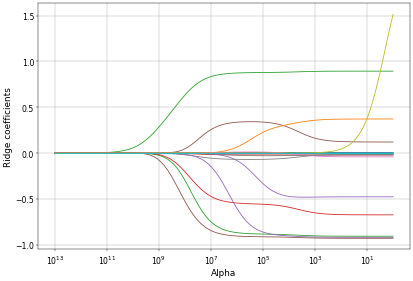

In [24]:
plt.figure(figsize = (12,8), dpi=40)
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 16)
plt.ylabel('Ridge coefficients', fontsize = 16)
plt.grid()
plt.show()

Cuanto mayor es alfa, mayor es la regularización por eso con alpha = 10e12 todos los valores convergen y cuando es menor todos los valores divergen pero son mas o menos estables en nuestro caso se da con alpha igual a 100. Otra forma de ver esto es que cuando todos los coeficientes estan al rededor de 0 queire decir que la regularizacion es tan fuerte que todas las caracteristicas son irrrelevantes. Si nos damos cuenta que esto ha sido lo que hemos cogido para nuesto modelo [10e-3, 10e-2,10e-1,1] haciendo  que ninguna caracteristica fuese relevante. Esto se hizo a posta para entenderlo ahora y por eso nuestro modelo regularizadon no funciona mejor que sin regularizar cosa que no tiene sentido.

#importancia de las caracteristicas para ridge:
Se puede hacer igual que para linear regression usando la libreria statsmodels pero con el metodo fit_regularized para este efecto.

# Regresión Polinomial
Basicamente coges el dataset y multiplicas caracteristcas entre ellas 1 a 1 o elevas una caracteristica al cuadrado para aumentar los datos de entrada y obtener distintas relaciones entre caracteristicas aumentando el grado de los atributos y usando polinomios en lugar de caracteristicas de orden 1 pero que se multiplican por los pesos correspondientes y se suman como una regresion lineal normal

Podemos obtener todos los coeficientes obtenidos con:

In [25]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0]) # coeficientes obtenidos al usar atributos al cuadrado  de los datos de entrada y relaciones entre atributos
print(reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0]) # coeficientes obtenidos solo al usar relaciones entre atributos

253
232


#Interpretación de los coeficientes y atributos de mayor prioridad
Se hace igual que con los otros modelos de regresión lineal

Regresión Logística:
Tiene coeficientes e intercept como un modelo de regresión lineal pero las predicciones usan una formula distinta.

In [26]:
coefs_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

stdv = np.std(X_train,0)
abs(coefs_log.reshape(21,)*stdv).sort_values(ascending=False)

coefficients:	[[-2.05987843e-03  1.29934323e-03  1.74997966e-01  4.42238162e-03
  -2.49479887e-03 -2.27774031e-03  1.68246599e-06 -5.90143858e-02
  -2.00100618e-03  6.46539558e-03 -2.92855932e-04 -1.00810989e-02
  -3.10792688e-03 -1.82884670e-01 -1.45411192e-01 -7.18679393e-03
  -1.79242416e-01 -1.51102394e-02 -6.14539021e-03 -2.66809862e-03
   0.00000000e+00]]
intercept:	[-0.00266815]


DEP_DELAY              7.746181
CRS_ELAPSED_TIME       4.684314
LATE_AIRCRAFT_DELAY    4.429379
DISTANCE               4.198803
NAS_DELAY              2.003773
WEATHER_DELAY          1.911098
CRS_DEP_TIME           1.032838
DEP_TIME               0.669041
ARR_AFPH               0.356500
DEP_AFPH               0.156795
CRS_ARR_TIME           0.154667
DEP_MONTH              0.051567
TAXI_OUT               0.022479
DEP_DOW                0.012281
SECURITY_DELAY         0.011780
ARR_RFPH               0.002242
DEP_RFPH               0.001409
WHEELS_OFF             0.000869
PCT_ELAPSED_TIME       0.000211
ORIGIN_HUB             0.000004
DEST_HUB               0.000000
dtype: float64

# Iterpretabilidad de los coeficientes

Le pasa igual que a los modelos de regresión lineal pero ahora cuando el valor de un atributo aumenta en una unidad, no aumenta el valor de la prediccion de forma lineal (multiplicado por la escala del coeficiente/peso) sino que aumenta de forma exponencial al coeficiente (e^( peso_n*x_n)) siendo x_n=atributo n

# La importancia de los atributos para la regresion logistica

 Es tema de debate ya que no terminan de ponerse de acuerdo los expertos. Una forma aceptada y simple es multiplicar cada coeficiente por su variación estandard y asi obtienes los atributos mas importantes

# Arboles de decisión:
## Interpretabilidad de los coeficienes
Se puede ver de forma visual aunque solo vamos a graficar hasta la profundidad del arbol 2 ya que si no no se graficaría bine pero se podria ir graficando el arbol por capas.

*El gini index indica donde las dos ramas son lo más diferentes posibles.
*Los CART classificatoin and regression trees son interpretables ya que se basan en una formula matematica simple de entender aunque hay algunos que usan métodos mas complejos para su construccion como boosting, bagging, stacking o incluso PCA.

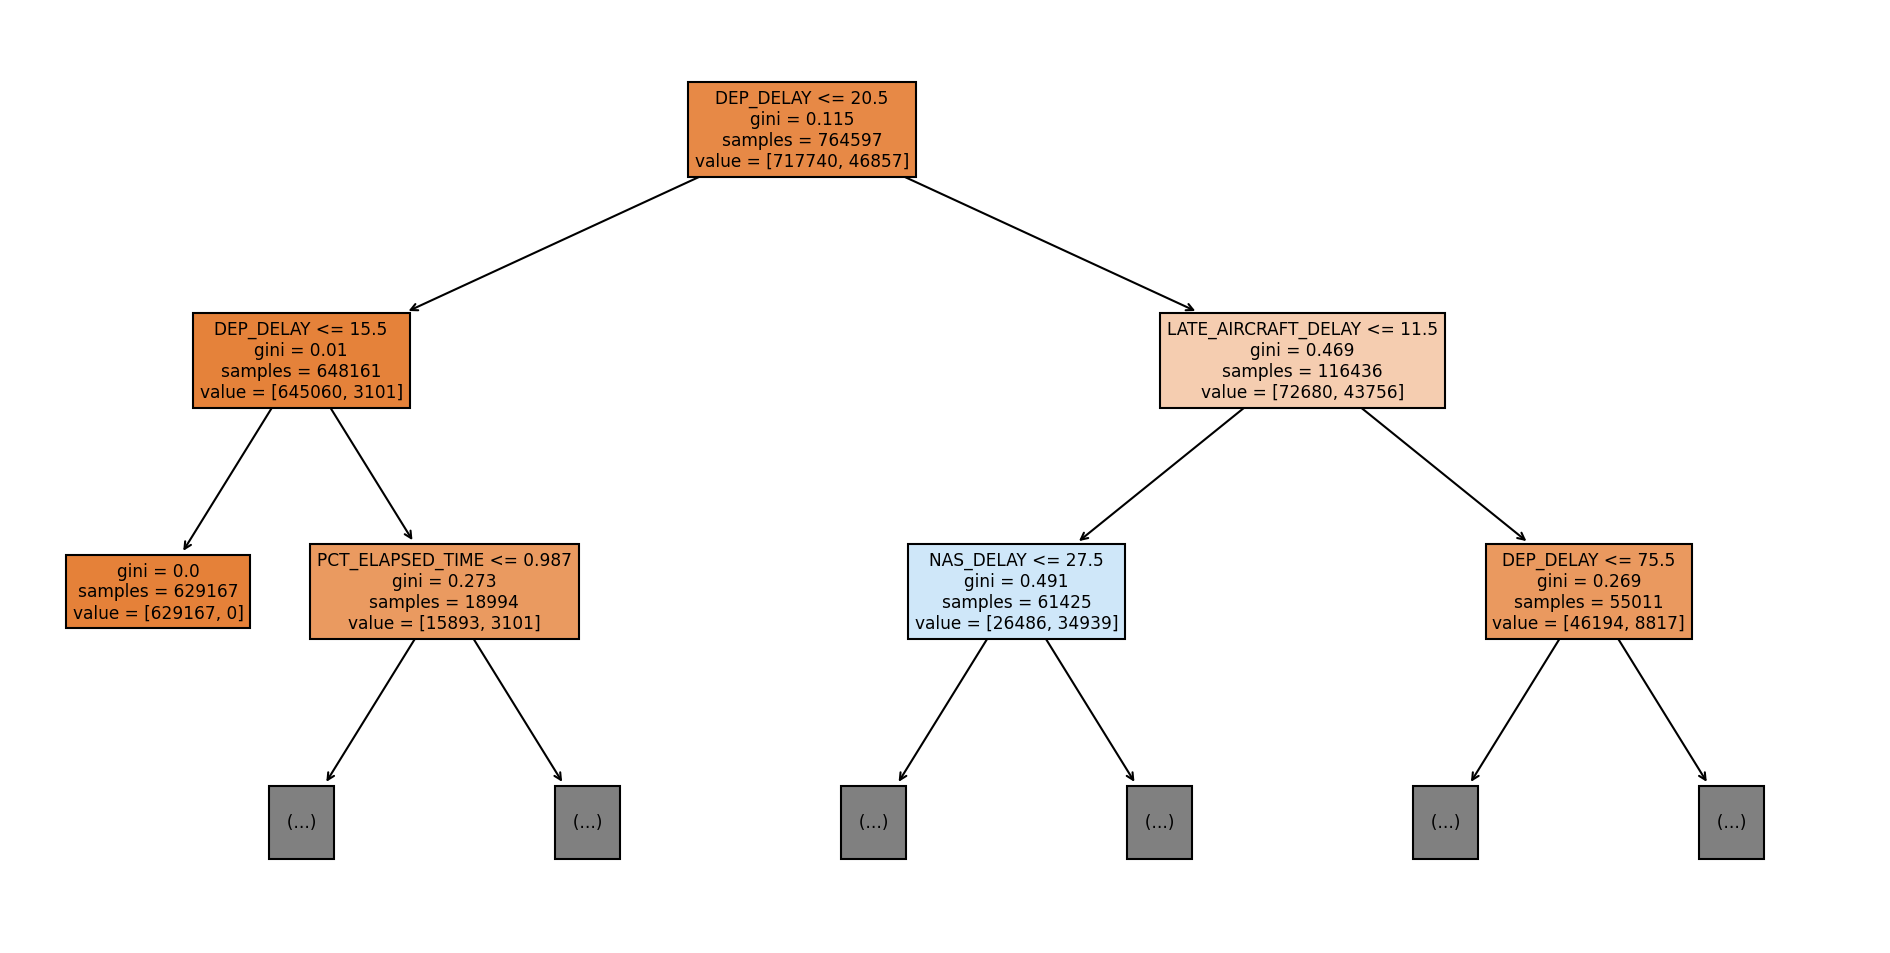

In [27]:
fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(16,8), dpi=150)
tree.plot_tree(class_models['decision_tree']['fitted'], feature_names=X_train.columns.values.tolist(), filled=True, max_depth=2)
fig.show()

Otra forma en la que podemos visualizar el árbol pero con menos detalle (sin ver el gini index y el tamaño de la muestra) es asi:

In [28]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],
                             feature_names=X_train.columns.values.tolist()
                             )
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

# Importancia de los atributos
Para este caso es bastante directo. Cuanto mas arriba del arbol este, mas importancia tiene ya que da un resultado de prediccion antes (nodo hoja)

In [29]:
dt_imp_df = pd.DataFrame(
    {
        'feature': X_train.columns.values.tolist(),
        'importance': class_models['decision_tree']['fitted'].feature_importances_
    }
).sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.527482
16,LATE_AIRCRAFT_DELAY,0.199153
8,PCT_ELAPSED_TIME,0.105381
13,WEATHER_DELAY,0.101649
14,NAS_DELAY,0.062732
15,SECURITY_DELAY,0.001998
9,DISTANCE,0.001019
7,CRS_ELAPSED_TIME,0.000281
5,TAXI_OUT,0.000239
6,WHEELS_OFF,0.000035


A resaltar, hemos usado atributos que para predicciones que no sabemos a priory como retraso por brechas de seguridad o mal tiempo cosa que no podemos saber hasta que ya ha sucedido. Esto podria producir una falta de informacion en nuestro modelo produciendo fallos/mal funcionamiento de nuestro modelo.

# Rulefit
Se obtienen coeficientes de regularizacion usando reglas a partir de un arbol de decisión. Este modelo se puede entender como una secuencia de if-then-else. Solo puede ser interpretado por ello de forma secuencial pero tambien esto es su gran ventaja.

#Interpretacion e importancia de caracteristicas/atributos:

In [30]:
rulefit_df = reg_models['rulefit']['fitted'].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(
    by="importance", ascending=False
)
rulefit_df

,rule,type,coef,support,importance
46,WEATHER_DELAY <= 166.0 & DEP_DELAY > 344.0 & L...,rule,210.729509,0.001684,8.639055
36,LATE_AIRCRAFT_DELAY <= 333.5 & DEP_DELAY > 477.5,rule,161.195448,0.001122,5.397219
16,LATE_AIRCRAFT_DELAY,linear,-0.388728,1.000000,4.554772
2,DEP_DELAY,linear,0.162649,1.000000,4.255317
155,LATE_AIRCRAFT_DELAY <= 198.0 & DEP_DELAY <= 78...,rule,-93.898861,0.001496,3.629657
...,...,...,...,...,...
10,CRS_ARR_TIME,linear,-0.000102,1.000000,0.050953
168,DEP_DELAY > 880.5,rule,1.190599,0.000748,0.032555
91,DEP_DELAY > 849.0 & DEP_RFPH <= 0.705958738923...,rule,2.299919,0.000187,0.031453
88,DEP_DELAY <= 236.5 & DEP_DELAY <= 884.5,rule,-0.376791,0.995885,0.024121


Si el coeficiente es de tipo lineal, funciona como cualquier coeficiente de regression lineal. Los que son de tipo regla, se tratan como condiciones binarias en un modelo de regresion lineal. Pej, si se cumple la regla, se aplica su coeficiente para la prediccion. El modelo usa metodos no lineales para obtener reglas tambien.

Pd la explicacion que da de estas reglas es tan buena que puedes usarlas para contruir otros modelos a partir de ellas.

# KNN (K vecinos mas cercanos / K nearest neighbour)

Usa los k vecnos mas cercano para predecir usando su media o para clasificar usando la clase que mas se repite entre esos vecinos.

Solo tiene interpretabilidad local ya que como no hay ningun modelo que extraiga coeficientes/reglas y demas que se usen para todas las predicciones no hay interpretabilidad global modular ni holistica. Solo podemos entender los resultados de predicciones especificas al visualizar los vecinos mas cercanos al dato de entrada

In [31]:
# usamos el dato numero 721043 para verlo
# recuerda que no hemos entrenado KNN ya que tardaba la vida en entrenar
print(X_test.loc[721043,:])

CRS_DEP_TIME            655.000000
DEP_TIME               1055.000000
DEP_DELAY               240.000000
DEP_AFPH                 90.800000
DEP_RFPH                  0.890196
TAXI_OUT                 35.000000
WHEELS_OFF             1130.000000
CRS_ELAPSED_TIME        259.000000
PCT_ELAPSED_TIME          1.084942
DISTANCE               1660.000000
CRS_ARR_TIME            914.000000
ARR_AFPH                 40.434783
ARR_RFPH                  1.064073
WEATHER_DELAY             0.000000
NAS_DELAY                22.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY     221.000000
DEP_MONTH                10.000000
DEP_DOW                   4.000000
ORIGIN_HUB                1.000000
DEST_HUB                  0.000000
Name: 721043, dtype: float64


In [32]:
# valor real:
print(y_test_class[721043])

1


In [33]:
# prediccion con KNN
# print(class_models['knn']['preds'][X_test.index.get_loc(721043)]) # se usa get_loc ya que el resultado es un numpy no un pd.Dataframe y no podemos acceder a el directamente por su indice

In [34]:
# encontrar los vecinos que han hecho que obtengamos esa predicción
#print(class_models['knn']['fitted'].kneighbors(X_test.loc[721043,:].values.reshape(1,21), 7)) # tenemos que reajustar el tamaño de los datos para que tengan la misma forma
# que los datos de entrenamiento. La forma tiene que ser (n, 21) donde n es el numero de observaciones. En nuestro caso 1 ya que solo queremos el punto mas cercano a los 7 vecinos (K). 21 es el numero
# de caracteristicas(columnas) de los datos de entrenamiento
# primer array es igual a la distancia a cada puntoy segundo array es la localizacion de esos puntos en los datos de entrenamiento

puedes alterar el valor de k y la forma de medir la distancia (euclidea, mahalanobis, minkowski,seuclidean, etc). Cuando tus datos son binarios, las distancias tienen que medirse con con algorimtos hechos para ellos como hamming or canberra. Podemos ver que distancia se estaba usando con:

Importancia de las caracteristicas. Esto es una interpretacion global del modelo pero como Knn tiene una naturaleza hiperlocal no se puede obtener.

In [35]:
#print(class_models['knn']['fitted'].effective_metric_)

# Naïve Bayes:
Son como los clasificadores GLM pero estos siempre asumen que los datos de entrada tienen un impacto independiene a la salida lo cual es una suposición bastante fuerte y por esta suposicion se les llama Naïve. Al solo retornar probabilidades solo pueden ser usados como clasificadores y hay de Bernouilly, Multinomial y Gausiana que es el de nuestro caso que usa las probabilidades condicionadas.

Para saber la probabilidad de cada clase es bastante simple:

In [36]:
print(class_models['naive_bayes']['fitted'].class_prior_)

[0.93871674 0.06128326]


## Interpretacion de los pesos e importancia de los atributos de los datos:

Los pesos que calcula en este caso el modelo son la varianza (desviacion estandard al cuadrado) y la media de cada de los atributos de clase que influye en la prediccion de y. Podemos obtener las varianzas obtenidas con:

In [37]:
print(class_models['naive_bayes']['fitted'].var_)

[[2.50123026e+05 2.61324730e+05 9.21572605e+02 1.26123968e+03
  2.08339528e-01 9.58074414e+01 2.62606651e+05 6.30102550e+03
  1.13475535e-02 4.22470414e+05 2.75433641e+05 1.25314386e+03
  3.48655340e-01 1.11234714e+02 1.91877186e+02 2.80302201e+00
  5.06561612e+02 1.17346654e+01 3.99122491e+00 4.24541988e-04
  4.21755471e-04]
 [2.60629652e+05 2.96009867e+05 1.19307931e+04 1.14839167e+03
  1.99929921e+00 1.20404927e+02 3.08568277e+05 6.29066219e+03
  1.38936741e-02 4.10198938e+05 3.28574000e+05 1.09023147e+03
  3.08997044e+00 7.79140423e+01 1.56184090e+02 9.12112286e-01
  2.11279954e+03 1.02712368e+01 4.02943162e+00 4.21755471e-04
  4.21755471e-04]]


Obteniendo en nuestro caso 2 dimensiones. Una para la clase negativa y otra para la clase positiva

Tambien podemos obtener las medias con:

In [38]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.30740577e+03 1.31006271e+03 5.14196506e+00 5.45864877e+01
  1.09377996e+00 1.87120810e+01 1.33552258e+03 1.70734929e+02
  9.71131781e-01 1.01824369e+03 1.48438931e+03 5.39873058e+01
  1.09644787e+00 7.39971299e-01 2.85434558e+00 2.41814585e-02
  4.14674395e+00 6.55045281e+00 2.95035528e+00 9.99997213e-01
  0.00000000e+00]
 [1.41305545e+03 1.48087887e+03 8.45867640e+01 6.14731036e+01
  1.25429654e+00 1.99378321e+01 1.49409412e+03 1.72229998e+02
  9.83974416e-01 1.04363666e+03 1.54821862e+03 4.26486417e+01
  1.36373798e+00 4.50733082e-01 4.71991378e+00 2.11281132e-02
  1.40744819e+01 6.73367907e+00 3.04251232e+00 1.00000000e+00
  0.00000000e+00]]


Podemos usar la media y desviacion estandard para calcular las probabilidades condicionadas de obtener el resultado usando cada atributo y así interpretar los resultados.

Este modelo es bastante bueno para deteccion de spam y recomendadores pero su suposicion de que los atributos de los datos son totalmente independientes reduce su eficiencia.

#Descubriendo nuevos Modelos (Glass-box) Interpretables

Explainable Boosting Machine (EBM)

In [39]:
# Este modelo tarda bastante mas en entrenar es por ello que vamos a simplificar el dateset usando solo los 8 atributos mas relevantes
# segun los modelos que hemos visto antes.
feature_samp = ['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',\
                'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
X_train_abbrev = X_train[feature_samp]
X_test_abbrev = X_test[feature_samp]

# Muestreamos sobre las observaciones (No vamos a cojer todos los ejemplos tampoco solo el 10%)
sample_size = 0.1
sample_idx = np.random.choice(X_train.shape[0], math.ceil(X_train.shape[0]*sample_size), replace=False)

In [40]:
ebm_mdl = ExplainableBoostingClassifier()
ebm_mdl.fit(X_train_abbrev.iloc[sample_idx], y_train_class.iloc[sample_idx])

ExplainableBoostingClassifier()

Interpretación global

In [41]:
show(ebm_mdl.explain_global())

# Interpretracioin local
Funciona igual que global pero eliges un dato (conjunto de atributos) contreto para realizar la prediccion


In [42]:
ebm_lcl = ebm_mdl.explain_local(X_test_abbrev.iloc[76:77],\
                                y_test_class[76:77], name='EBM') # elegimos el caso 76
show(ebm_lcl)

#Performance
Obtenemos una medida con ROC AUC similar a la que obtubimos con nuestros mejores modelos y podríamos obtener un comporttamiento incluso mejor si usasemos todo nuestro dataset original y no solo el 10% como hacemos ahora

In [43]:
ebm_perf = ROC(ebm_mdl.predict_proba).explain_perf(X_test_abbrev,y_test_class, name='EBM')
show(ebm_perf)

Modelo GAMI-Net
GAM que usa machine learning

In [44]:
# primero hay que indicarle con un diccionario que tipo de atributos son los que forman el dato (continuo, binario, categorico). En nuestro caso son todos continuos
meta_info = {col:{"type":"continuous"} for col in X_train_abbrev.columns}

# creamos una copia de los datos de entrenamiento y test abrebiados y los escalamos almacenando tambien las escalas en el diccionario
X_train_abbrev2 = X_train_abbrev.copy()
X_test_abbrev2 = X_test_abbrev.copy()

for key in meta_info.keys():
  scaler = MinMaxScaler()
  X_train_abbrev2[[key]] = scaler.fit_transform(X_train_abbrev2[[key]])
  X_test_abbrev2[[key]] = scaler.transform(X_test_abbrev2[[key]])
  meta_info[key]["scaler"] = scaler

# despues vamos a añadir informacion del target
meta_info["CARRIER_DELAY"] = {"type":"target", "values":["no", "yes"]}

# combertimos todo a numpy
X_train_abbrev2 = X_train_abbrev2.to_numpy().astype(np.float32)
X_test_abbrev2 = X_test_abbrev2.to_numpy().astype(np.float32)
y_train_class2 = y_train_class.to_numpy().reshape(-1,1)
y_test_class2 = y_test_class.to_numpy().reshape(-1,1)

In [45]:
print(meta_info)

{'DEP_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'LATE_AIRCRAFT_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'PCT_ELAPSED_TIME': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'WEATHER_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'NAS_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'SECURITY_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'DISTANCE': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'CRS_ELAPSED_TIME': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'CARRIER_DELAY': {'type': 'target', 'values': ['no', 'yes']}}


Inicializamos y entrenamos el modelo
Argumentos clave:
- Interaction_num = Cuantas interacciones top debería considerar (las 8 que le pasamos)
- GAMINet entrena 3 redes neuronales distintas es por ello que usa 3 epochs distinos y el early_stop_thres y lr_bp son una lista de 3 argumentos(uno por epoch)
- Listas para la arquitectura de la net donde cada item corresponde a los nodos de cada capa (interact_arch y subnet_arch)
- Y tambien batch_size, activation_function, forzar condición de herencia, umbral de perdida para parado anticipado y porcentaje de datos de entrenamiento usado para validación
- Finalmente encontramos rescricciones de monotendencia(mono_increasing_list o mono_decreasing_list)

*Sparsity: solo las mejores caracteristicas y sus interacciones se guardan
*Heredity: Ineraccion por pares que solo puede guardarse si al menos uno de los atributos padre esta incluido
*Claridad Marginal: No-ortogonalidad en las interacciones es penalizada para aproximar mayor claridad marginal

In [46]:
gami_mdl = GAMINet(meta_info=meta_info, interact_num=8, task_type="Classification",
                   main_effect_epochs=80, interaction_epochs=60, tuning_epochs=40,
                   lr_bp=[0.0001]*3, early_stop_thres=[10]*3,
                   interact_arch=[20]*5, subnet_arch=[20]*5,
                   batch_size=200, activation_func=tf.nn.relu,
                   heredity=True, loss_threshold=0.01, val_ratio=0.2,
                   verbose=True, reg_clarity=1, random_state=rand)
gami_mdl.fit(X_train_abbrev2, y_train_class2)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.12491, val loss: 0.12348
Main effects training epoch: 2, train loss: 0.09241, val loss: 0.09158
Main effects training epoch: 3, train loss: 0.06907, val loss: 0.06826
Main effects training epoch: 4, train loss: 0.04795, val loss: 0.04759
Main effects training epoch: 5, train loss: 0.04089, val loss: 0.04055
Main effects training epoch: 6, train loss: 0.03790, val loss: 0.03747
Main effects training epoch: 7, train loss: 0.03482, val loss: 0.03490
Main effects training epoch: 8, train loss: 0.03230, val loss: 0.03228
Main effects training epoch: 9, train loss: 0.03133, val loss: 0.03127
Main effects training epoch: 10, train loss: 0.02964, val loss: 0.02949
Main effects training epoch: 11, train loss: 0.02824, val loss: 0.02779
Main effects training epoch: 12, train loss: 0.02756, val loss: 0.02710
Main effects training e

# Plot results
Graficamos las funciones de perdida con los datos de entrenamiento durante las 3 fases de entrenamiento y con plot_regularization podemos graficar la salida para la regularización de ambas redes (efectos principales e interacciones). Las graficas las podriamos guardar si quisieramos(no es el caso).

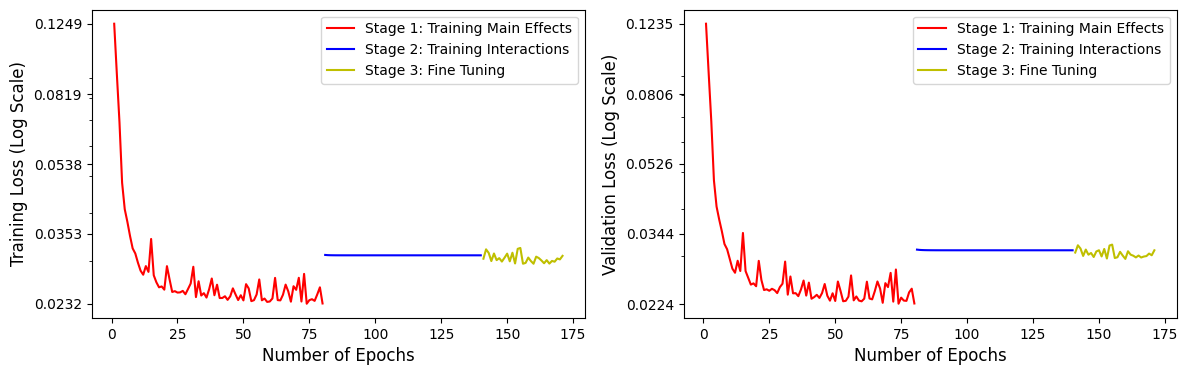

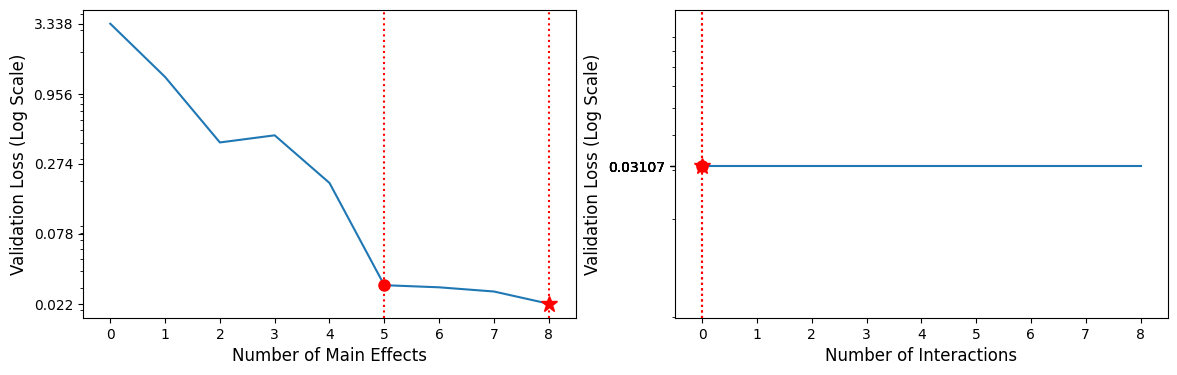

In [47]:
data_dict_logs = gami_mdl.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs)
plot_regularization(data_dict_logs)

vemos como va reduciendo la funcion de perdida durante las 3 etapas secuenciales mientras que se van regularizando para solo mantener las menores características e interacciones posibles.

## Interpretación global
La podemos extraer en forma de diccionario y despues graficarla:

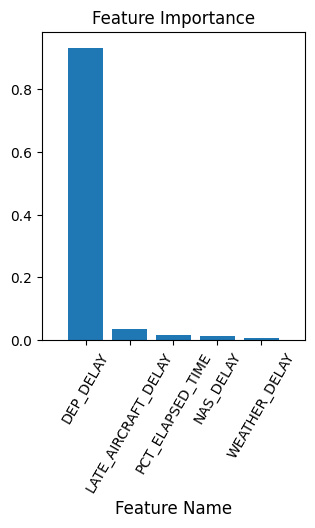

In [48]:
data_dict_global = gami_mdl.global_explain(save_dict=True)
feature_importance_visualize(data_dict_global)
plt.show()

vemos como la caracteristica mas relevante es Dep_delay y solo hay una interaccion entrecaracteristicas dentro de los atributos mas importantes.

Podemos también utilizar el gráfico global_visuallize_density() para generar gráficos de dependencia parcial:

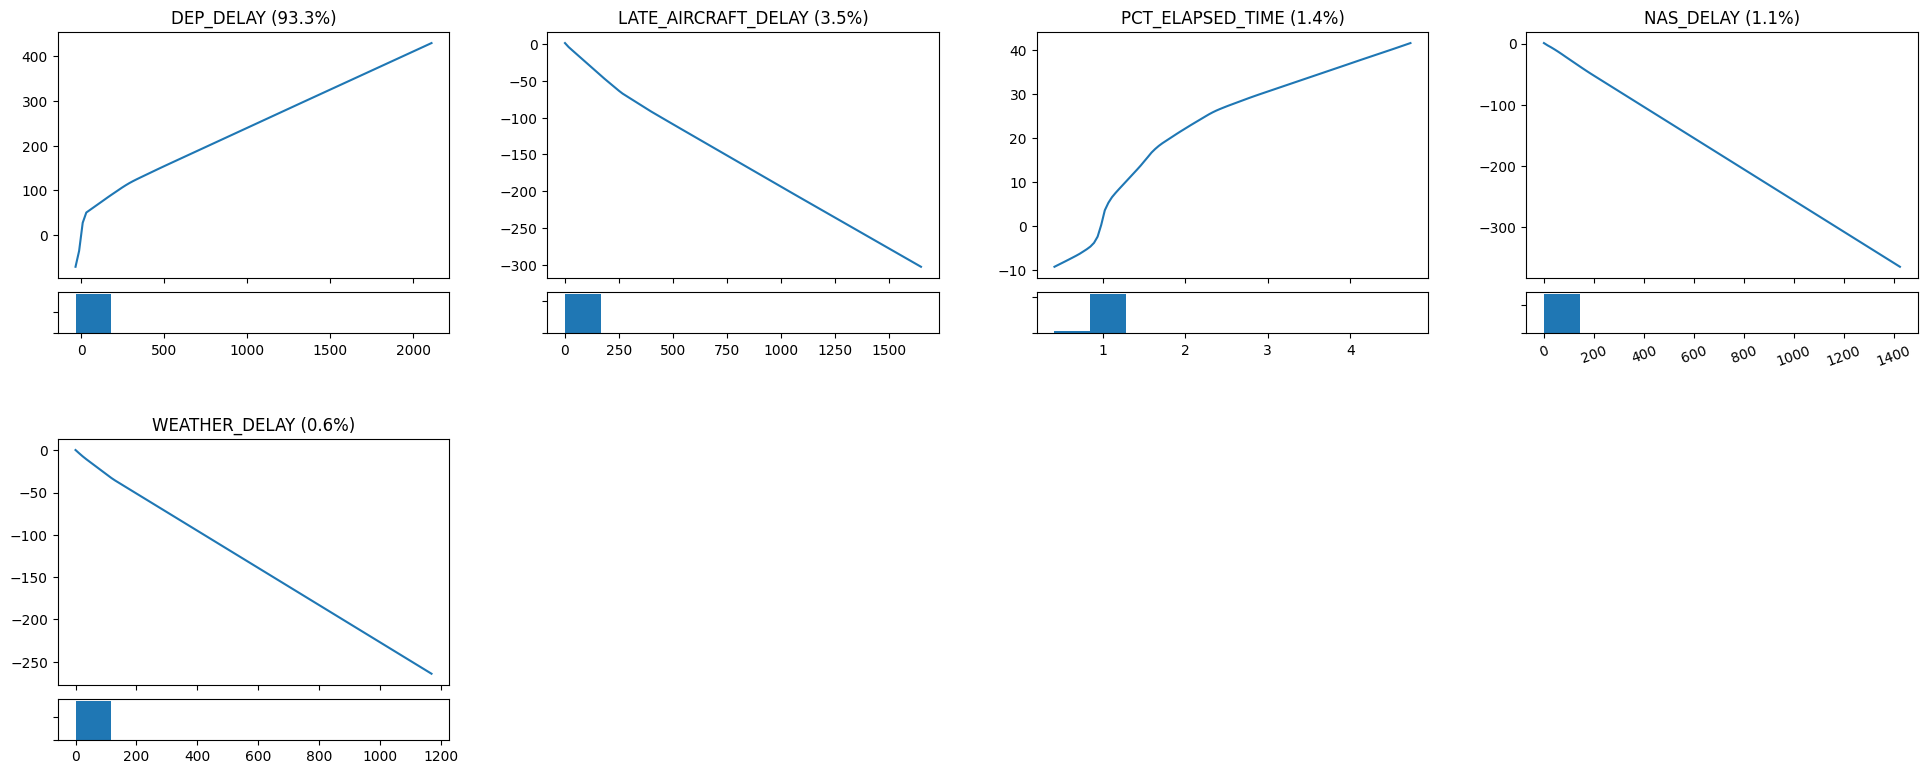

In [49]:
global_visualize_density(data_dict_global, name="flight_delay_global",
                         main_effect_num=8, interaction_num=1, cols_per_row=4, save_png=True, save_eps=True)

Interpretación local:
Vemos la explicación para un caso concreto #73:

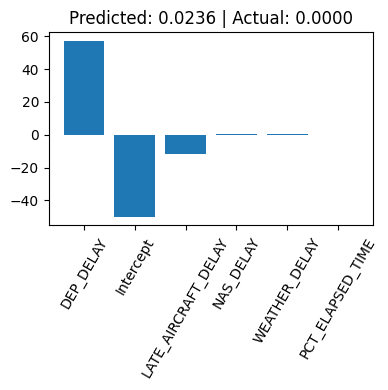

In [50]:
data_dict_local = gami_mdl.local_explain(
    X_test_abbrev2[[73]], y_test_class2[[73]], save_dict=False
)
local_visualize(data_dict_local[0])
plt.tight_layout()
plt.show()

Nota, vemos como el peso de DEP_DELAY es contrarestado por el intercept, esto se debe a que nuestros datos estan desbalanceados(solo un 6% de casos positivos de retraso) por tanto es normal que al final el intercept sea asi.

# Performance
Solo hay que obter los puntuajes(y_test_prob) y predicciones(y_test_pred) para los datos de test y obtener las metricas con sklearn:

In [51]:
y_test_prob = gami_mdl.predict(X_test_abbrev2)
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
print('accuracy: %.3g, recall: %.3g, roc auc: %.3g, f1: %.3g, mcc: %.3g' %\
      (metrics.accuracy_score(y_test_class2, y_test_pred),
       metrics.recall_score(y_test_class2, y_test_pred),
       metrics.roc_auc_score(y_test_class2, y_test_prob),
       metrics.f1_score(y_test_class2, y_test_pred),\
       metrics.matthews_corrcoef(y_test_class2, y_test_pred)))

accuracy: 0.99, recall: 0.919, roc auc: 0.998, f1: 0.918, mcc: 0.913


El resultado no esta mal teniendo en cuenta que hemos solo usado el 10% de nuestros datos y que el recall entra en el top 3 de nuestros modelos.